In [5]:
%matplotlib inline
from IPython.display import display
from matplotlib import pyplot as plt

import os
import sys
import torch
import random
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import seaborn as sns
from datetime import datetime

#Plotting 
from pandas.plotting import scatter_matrix

#Libraries for Statistical Models
import statsmodels.api as sm

sys.path.append('../')
from MyPyUtil.logconf import logging
from MyPyUtil.util import show_more_rows, seed_everything

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')


In [6]:
# logging
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)

seed_everything()

pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False
pd.options.display.float_format = "{:.3f}".format

# max output width in numpy
np.set_printoptions(
    threshold=sys.maxsize,  # 20,
    edgeitems=10,
    linewidth=140,
    formatter=dict(float=lambda x: "%.3g" % x),
)  # float arrays %.3g

data_dir = f"{os.getcwd()}/../data/"
resources_dir = f"{os.getcwd()}/../resources/"

if os.path.exists(resources_dir) == False:
    os.makedirs(resources_dir, exist_ok=True)

if os.path.exists(data_dir) == False:
    os.makedirs(data_dir, exist_ok=True)

**download stocks list from ftp://ftp.nasdaqtrader.com/symboldirectory**  
[**reference: nasdaqtrader**](https://www.nasdaqtrader.com/trader.aspx?id=symboldirdefs)

- **Market Category:** The category assigned to the issue by NASDAQ based on Listing Requirements. Values:  
   Q = NASDAQ Global Select MarketSM  
   G = NASDAQ Global MarketSM  
   S = NASDAQ Capital Market

- **Test Issue:** Indicates whether or not the security is a test security. Values:  
   Y = yes, it is a test issue.  
   N = no, it is not a test issue.

- **Financial Status:** Indicates when an issuer has failed to submit its regulatory filings on a timely basis, has failed to meet NASDAQ's continuing listing standards, and/or has filed for bankruptcy. Values include:
  D = Deficient: Issuer Failed to Meet NASDAQ Continued Listing Requirements  
  E = Delinquent: Issuer Missed Regulatory Filing Deadline  
  Q = Bankrupt: Issuer Has Filed for Bankruptcy  
  N = Normal (Default): Issuer Is NOT Deficient, Delinquent, or Bankrupt.  
  G = Deficient and Bankrupt  
  H = Deficient and Delinquent  
  J = Delinquent and Bankrupt  
  K = Deficient, Delinquent, and Bankrupt


In [7]:
from ftplib import FTP

# Connect to the FTP server
ftp = FTP("ftp.nasdaqtrader.com")
ftp.login(user="anonymous", passwd="aaa@aaa.com")

# Change to the desired directory
ftp.cwd("symboldirectory")

# Download a file (e.g., 'example.txt') to the local machine
with open("nasdaqlisted.txt", "wb") as local_file:
    ftp.retrbinary("RETR nasdaqlisted.txt", local_file.write)

# Close the FTP connection
ftp.quit()

'221 Goodbye.'

In [8]:
stocks_list = pd.read_csv("nasdaqlisted.txt", delimiter="|")
stocks_list.drop(index=stocks_list.index[-1], axis=0, inplace=True)
stocks_list = stocks_list[
    (stocks_list["Test Issue"] == "N")
    & (stocks_list["ETF"] == "N")
    & (stocks_list["Financial Status"] == "N")
]
display(stocks_list)
stocks_list.groupby("Market Category").count()["Symbol"]

,Symbol,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size,ETF,NextShares
0,AACG,ATA Creativity Global - American Depositary Sh...,G,N,N,100.000,N,N
1,AACI,Armada Acquisition Corp. I - Common Stock,G,N,N,100.000,N,N
2,AACIU,Armada Acquisition Corp. I - Unit,G,N,N,100.000,N,N
3,AACIW,Armada Acquisition Corp. I - Warrant,G,N,N,100.000,N,N
4,AADI,"Aadi Bioscience, Inc. - Common Stock",S,N,N,100.000,N,N
...,...,...,...,...,...,...,...,...
4912,ZURA,Zura Bio Limited - Class A Ordinary shares,S,N,N,100.000,N,N
4913,ZURAW,Zura Bio Limited - Warrant,S,N,N,100.000,N,N
4914,ZVRA,"Zevra Therapeutics, Inc. - Common Stock",Q,N,N,100.000,N,N
4920,ZYME,Zymeworks Inc. - Common Stock,Q,N,N,100.000,N,N


Market Category
G     825
Q    1546
S    1283
Name: Symbol, dtype: int64

In [9]:
display(stocks_list.isnull().sum())
NaN_symbol = stocks_list[stocks_list["Symbol"].isnull()]
display(NaN_symbol)

Symbol              1
Security Name       0
Market Category     0
Test Issue          0
Financial Status    0
Round Lot Size      0
ETF                 0
NextShares          0
dtype: int64

,Symbol,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size,ETF,NextShares
2996,NaN,Nano Labs Ltd - Class A Ordinary Shares,G,N,N,100.000,N,N


In [10]:
stocks_list.drop(NaN_symbol.index, inplace=True)
display(stocks_list)
display(stocks_list.groupby("Market Category").count()["Symbol"])

,Symbol,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size,ETF,NextShares
0,AACG,ATA Creativity Global - American Depositary Sh...,G,N,N,100.000,N,N
1,AACI,Armada Acquisition Corp. I - Common Stock,G,N,N,100.000,N,N
2,AACIU,Armada Acquisition Corp. I - Unit,G,N,N,100.000,N,N
3,AACIW,Armada Acquisition Corp. I - Warrant,G,N,N,100.000,N,N
4,AADI,"Aadi Bioscience, Inc. - Common Stock",S,N,N,100.000,N,N
...,...,...,...,...,...,...,...,...
4912,ZURA,Zura Bio Limited - Class A Ordinary shares,S,N,N,100.000,N,N
4913,ZURAW,Zura Bio Limited - Warrant,S,N,N,100.000,N,N
4914,ZVRA,"Zevra Therapeutics, Inc. - Common Stock",Q,N,N,100.000,N,N
4920,ZYME,Zymeworks Inc. - Common Stock,Q,N,N,100.000,N,N


Market Category
G     825
Q    1546
S    1283
Name: Symbol, dtype: int64

In [11]:
sectors_file = f"{resources_dir}/sectors.csv"
if os.path.exists(sectors_file):
    sectors = pd.read_csv(f"{resources_dir}/sectors.csv").fillna("")
    sectors.drop(columns=sectors.columns[0], axis=1, inplace=True)
    display(sectors.groupby("Sector").count())
else:
    sectors = pd.DataFrame(columns=["Symbol", "Sector"])
    display(sectors)

,Symbol
Sector,
,191
Basic Materials,88
Communication Services,183
Consumer Cyclical,324
Consumer Defensive,152
Energy,75
Financial Services,917
Healthcare,977
Industrials,354


In [12]:
import yfinance as yfin

tmp_list = stocks_list.merge(sectors, how="left", on="Symbol")
stocks_without_sector = tmp_list[tmp_list.Sector.isna()]
symbols_without_sector = stocks_without_sector.Symbol.values

retrived_tickers_info = [yfin.Ticker(symbol) for symbol in symbols_without_sector]
retrived_sectors = pd.DataFrame(
    data={
        "Symbol": symbols_without_sector,
        "Sector": [
            t.info["sector"] if "sector" in t.info.keys() else ""
            for t in retrived_tickers_info
        ],
    }
)

display(retrived_sectors)

,Symbol,Sector
0,AIRJ,
1,AIRJW,
2,ATOS,Healthcare
3,BTTX,Healthcare
4,CELU,Healthcare
5,CERO,Healthcare
6,CJJD,Healthcare
7,EGIO,Technology
8,INFN,Technology
9,SCTL,Healthcare


In [13]:
new_sectors = retrived_sectors.merge(sectors, on=["Symbol", "Sector"], how="outer")
new_sectors.to_csv(sectors_file)
new_sectors

,Symbol,Sector
0,A,Healthcare
1,AACG,Consumer Defensive
2,AACI,Financial Services
3,AACIU,Financial Services
4,AACIW,Financial Services
...,...,...
4011,ZURA,Healthcare
4012,ZURAW,
4013,ZVRA,Healthcare
4014,ZYME,Healthcare


In [14]:
stocks_list = stocks_list.merge(new_sectors, how="left", on="Symbol")

display(stocks_list)
stocks_list.groupby("Sector").Symbol.count()

,Symbol,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size,ETF,NextShares,Sector
0,AACG,ATA Creativity Global - American Depositary Sh...,G,N,N,100.000,N,N,Consumer Defensive
1,AACI,Armada Acquisition Corp. I - Common Stock,G,N,N,100.000,N,N,Financial Services
2,AACIU,Armada Acquisition Corp. I - Unit,G,N,N,100.000,N,N,Financial Services
3,AACIW,Armada Acquisition Corp. I - Warrant,G,N,N,100.000,N,N,Financial Services
4,AADI,"Aadi Bioscience, Inc. - Common Stock",S,N,N,100.000,N,N,Healthcare
...,...,...,...,...,...,...,...,...,...
3649,ZURA,Zura Bio Limited - Class A Ordinary shares,S,N,N,100.000,N,N,Healthcare
3650,ZURAW,Zura Bio Limited - Warrant,S,N,N,100.000,N,N,
3651,ZVRA,"Zevra Therapeutics, Inc. - Common Stock",Q,N,N,100.000,N,N,Healthcare
3652,ZYME,Zymeworks Inc. - Common Stock,Q,N,N,100.000,N,N,Healthcare


Sector
                          191
Basic Materials            67
Communication Services    177
Consumer Cyclical         284
Consumer Defensive        124
Energy                     55
Financial Services        859
Healthcare                936
Industrials               297
Real Estate                86
Technology                542
Utilities                  36
Name: Symbol, dtype: int64

In [15]:
stocks_with_empty_sector = stocks_list[stocks_list.Sector == ""]
stocks_list.drop(stocks_with_empty_sector.index, inplace=True)
display(stocks_list)

,Symbol,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size,ETF,NextShares,Sector
0,AACG,ATA Creativity Global - American Depositary Sh...,G,N,N,100.000,N,N,Consumer Defensive
1,AACI,Armada Acquisition Corp. I - Common Stock,G,N,N,100.000,N,N,Financial Services
2,AACIU,Armada Acquisition Corp. I - Unit,G,N,N,100.000,N,N,Financial Services
3,AACIW,Armada Acquisition Corp. I - Warrant,G,N,N,100.000,N,N,Financial Services
4,AADI,"Aadi Bioscience, Inc. - Common Stock",S,N,N,100.000,N,N,Healthcare
...,...,...,...,...,...,...,...,...,...
3648,ZUMZ,Zumiez Inc. - Common Stock,Q,N,N,100.000,N,N,Consumer Cyclical
3649,ZURA,Zura Bio Limited - Class A Ordinary shares,S,N,N,100.000,N,N,Healthcare
3651,ZVRA,"Zevra Therapeutics, Inc. - Common Stock",Q,N,N,100.000,N,N,Healthcare
3652,ZYME,Zymeworks Inc. - Common Stock,Q,N,N,100.000,N,N,Healthcare


## Load Stock Data


In [16]:
new_sectors.set_index("Symbol", inplace=True)
new_sectors

,Sector
Symbol,
A,Healthcare
AACG,Consumer Defensive
AACI,Financial Services
AACIU,Financial Services
AACIW,Financial Services
...,...
ZURA,Healthcare
ZURAW,
ZVRA,Healthcare


In [17]:
from collections import namedtuple
from MyPyUtil.util import is_contained
from tqdm import tqdm

tick_data_info = namedtuple("tick_data_info", "idx symbol sector tick_data")


def load_stk_data(stk_symbols, start, end, empty_vol_threshold):

    ticks_data = []

    error_download = []
    error_sector_not_found = []
    error_numerical = []
    error_volumn = []
    error_empty = []
    for idx, symbol in enumerate(tqdm(stk_symbols)):
        if new_sectors.loc[symbol].Sector == "":
            log.warning(f"{symbol}: Its sector cannot be found")
            error_sector_not_found.append(symbol)
            continue

        stk_file = f"{data_dir}{symbol}_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.csv"
        bLoad = False
        if os.path.isfile(stk_file):
            try:
                _stk_data = pd.read_csv(stk_file).set_index("Date")
                bLoad = True
                log.info(f"read {stk_file} completely!")
            except:
                None
        if bLoad == False:
            # _stk_data = web.get_data_yahoo(stk_tickers, start, end)
            try:
                _stk_data = yfin.download([symbol], start, end).dropna()
                _stk_data.to_csv(stk_file)
                log.info(
                    f"download {symbol} from yfin and write to {stk_file} completely!"
                )
            except:
                error_download.append(symbol)
                continue
        statistics = _stk_data.describe()
        if is_contained(statistics, 0):
            if is_contained(
                statistics.loc[:, ["Open", "High", "Low", "Close", "Adj Close"]], 0
            ) or is_contained(statistics.loc["std"], 0):
                log.warning(f"{symbol}: contains numerical errors. Ignore it.")
                error_numerical.append(symbol)
                continue
            else:
                empty_vol_index = _stk_data[_stk_data["Volume"] == 0].index
                if len(empty_vol_index) > empty_vol_threshold:
                    log.warning(
                        f"The total volume with a value of zero ({len(empty_vol_index)}) is greater than the threshold({empty_vol_threshold}). Ignore it."
                    )
                    error_volumn.append(symbol)
                    continue
                log.info(
                    f"A total of {len(empty_vol_index)} volume values ​​are zero. Delete these data."
                )

                cleaned_data = _stk_data.drop(empty_vol_index)
                log.info(
                    f"The cleaned data size is {len(cleaned_data)}. The original data size is {len(_stk_data)}."
                )
                if len(cleaned_data) == 0:
                    error_empty.append(symbol)
                    log.warning(f"The cleaned data size is {len(cleaned_data)}.")
                    continue
                _stk_data = cleaned_data

        ticks_data.append(
            tick_data_info(idx, symbol, new_sectors.loc[symbol].Sector, _stk_data)
        )
        log.info(f"{symbol}, size:{len(_stk_data)}")
    return ticks_data, (
        error_download,
        error_sector_not_found,
        error_numerical,
        error_volumn,
        error_empty,
    )

In [18]:
log.setLevel(logging.ERROR)

start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31)

empty_vol_threshold = 10
stks_data, (
    error_download,
    error_sector_not_found,
    error_numerical,
    error_volumn,
    error_empty,
) = load_stk_data(
    stocks_list.Symbol.values,
    start,
    end,
    empty_vol_threshold,
)
display(len(stks_data))

log.setLevel(logging.INFO)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
2024-03-15 18:43:44,046 ERROR    pid:8033 yfinance:182:download 
1 Failed download:
2024-03-15 18:43:44,046 ERROR    pid:8033 yfinance:195:download ['VWEWW']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[*********************100%%**********************]  1 of 1 completed
100%|█

2265

In [19]:
stks_data[0].tick_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-16,69.750,72.750,64.200,67.500,67.500,1527
2018-02-20,65.700,66.000,63.750,66.000,66.000,353
2018-02-21,60.000,74.850,60.000,71.250,71.250,733
2018-02-22,67.650,71.250,66.750,68.745,68.745,213
2018-02-23,65.250,67.500,65.250,67.500,67.500,360
...,...,...,...,...,...,...
2023-12-22,1.980,2.060,1.900,1.970,1.970,725600
2023-12-26,2.030,2.095,1.990,2.010,2.010,477200
2023-12-27,2.010,2.100,2.010,2.080,2.080,608300


In [20]:
import joblib

start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31)

stks_data_file = (
    f"{resources_dir}nasdaq_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.pkl"
)
joblib.dump(stks_data, stks_data_file)

['/mnt/AIWorkSpace/work/AI4StockMarket/StockPricePrediction/../resources/nasdaq_20140101-20231231.pkl']

In [21]:
stks_data_test = joblib.load(stks_data_file)
display(len(stks_data_test))
display(stks_data_test[0].tick_data)

2265

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-16,69.750,72.750,64.200,67.500,67.500,1527
2018-02-20,65.700,66.000,63.750,66.000,66.000,353
2018-02-21,60.000,74.850,60.000,71.250,71.250,733
2018-02-22,67.650,71.250,66.750,68.745,68.745,213
2018-02-23,65.250,67.500,65.250,67.500,67.500,360
...,...,...,...,...,...,...
2023-12-22,1.980,2.060,1.900,1.970,1.970,725600
2023-12-26,2.030,2.095,1.990,2.010,2.010,477200
2023-12-27,2.010,2.100,2.010,2.080,2.080,608300


In [22]:
import pandas_ta as ta
import talib as tb

help(ta.sma)
tick_data: pd.DataFrame = stks_data[0].tick_data
display(tick_data.ta.sma(length=5))
display(tb.MA(tick_data["Close"], timeperiod=5))

Help on function sma in module pandas_ta.overlap.sma:

sma(close, length=None, talib=None, offset=None, **kwargs)
    Simple Moving Average (SMA)
    
    The Simple Moving Average is the classic moving average that is the equally
    weighted average over n periods.
    
    Sources:
        https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/simple-moving-average-sma/
    
    Calculation:
        Default Inputs:
            length=10
        SMA = SUM(close, length) / length
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 10
        talib (bool): If TA Lib is installed and talib is True, Returns the TA Lib
            version. Default: True
        offset (int): How many periods to offset the result. Default: 0
    
    Kwargs:
        adjust (bool): Default: True
        presma (bool, optional): If True, uses SMA for initial value.
        fillna (value, optional): pd.DataFrame.fillna(value)
     

Date
2018-02-16      NaN
2018-02-20      NaN
2018-02-21      NaN
2018-02-22      NaN
2018-02-23   68.199
              ...  
2023-12-22    2.094
2023-12-26    2.048
2023-12-27    2.022
2023-12-28    2.030
2023-12-29    2.036
Name: SMA_5, Length: 1477, dtype: float64

Date
2018-02-16      NaN
2018-02-20      NaN
2018-02-21      NaN
2018-02-22      NaN
2018-02-23   68.199
              ...  
2023-12-22    2.094
2023-12-26    2.048
2023-12-27    2.022
2023-12-28    2.030
2023-12-29    2.036
Length: 1477, dtype: float64

In [23]:
short_ind = 5
long_ind = 10


def to_adjusted(stk_data):
    """
    Adjusted Open = Open * Adjusted Close / Close
    Adjusted High = High * Adjusted Close / Close
    Adjusted Low = Low * Adjusted Close / Close
    Adjusted volume = Volume / (Adjusted Close / Close)
    """
    ratio_data = stk_data["Adj Close"] / stk_data["Close"]
    adjusted_OHLV = pd.DataFrame(index=stk_data.index)
    adjusted_OHLV["Adj Open"] = ratio_data * stk_data["Open"]
    adjusted_OHLV["Adj High"] = ratio_data * stk_data["High"]
    adjusted_OHLV["Adj Low"] = ratio_data * stk_data["Low"]
    adjusted_OHLV["Adj Close"] = stk_data["Adj Close"]
    adjusted_OHLV["Adj Volume"] = (ratio_data * stk_data["Volume"]).astype("int")
    adjusted_OHLV["Pre Adj Close"] = stk_data["Adj Close"].shift(1)
    adjusted_OHLV["Pre Adj Volume"] = adjusted_OHLV["Adj Volume"].shift(1)
    adjusted_OHLV = adjusted_OHLV.dropna()
    adjusted_OHLV["Pre Adj Volume"] = adjusted_OHLV["Pre Adj Volume"].astype("int")
    adjusted_OHLV["B4_Adj Open pct"] = (
        adjusted_OHLV["Adj Open"] - adjusted_OHLV["Pre Adj Close"]
    ) / adjusted_OHLV["Pre Adj Close"]
    adjusted_OHLV["B4_Adj High pct"] = (
        adjusted_OHLV["Adj High"] - adjusted_OHLV["Pre Adj Close"]
    ) / adjusted_OHLV["Pre Adj Close"]
    adjusted_OHLV["B4_Adj Low pct"] = (
        adjusted_OHLV["Adj Low"] - adjusted_OHLV["Pre Adj Close"]
    ) / adjusted_OHLV["Pre Adj Close"]
    adjusted_OHLV["B4_Adj Volume pct"] = (
        adjusted_OHLV["Adj Volume"] - adjusted_OHLV["Pre Adj Volume"]
    ) / adjusted_OHLV["Pre Adj Volume"]

    return adjusted_OHLV

In [24]:
import talib as ta


# mpf绘图函数
def mpf_show(integer):

    # 默认是0 ，有标志的值是 -100 ，选择非0值，即出现形态位置的时间
    position = integer[integer != 0]
    # 如果没有数据，不绘图
    if len(position) != 0:
        print("position Pattern date:")
        print(position)
        # 出现形态的时间，前10天到后10天的期间K线
        for i in position.index:
            begin_date = i + datetime.timedelta(days=-10)
            end_date = i + datetime.timedelta(days=10)
            # 按时间段绘图
            df_candle = df.loc[
                (df.index >= begin_date.strftime("%Y-%m-%d"))
                & (df.index <= end_date.strftime("%Y-%m-%d"))
            ]
            plt.plot(
                df_candle, type="candle", title=i.strftime("%Y-%m-%d"), figsize=(6, 2)
            )
            plt.show()

        for i in position.index:
            begin_date = i + datetime.timedelta(days=-10)
            end_date = i + datetime.timedelta(days=10)

            df_candle = df.loc[
                (df.index >= begin_date.strftime("%Y-%m-%d"))
                & (df.index <= end_date.strftime("%Y-%m-%d"))
            ]
            # 按时间段数据
            print(df_candle[["open", "high", "low", "close", "pct_chg"]])


# 选择股票代码做测试
def test_candlestick_pattern(df, CDL):
    # df = get_data(r[0], start_date, end_date)
    # 只需要替换此处talib的Pattern Recognition不同函数即可
    integer = CDL(df["open"], df["high"], df["low"], df["close"])
    # integer = tlb.CDL3BLACKCROWS(df['open'], df['high'], df['low'], df['close'])
    mpf_show(integer)

&#128293; &#9778;
reference:

1. ![candlestick_patterns_8_trigrams](candlestick_patterns_8_trigrams.png)
2. [From Technical Indicators to Machine Learning: A Data-Driven Approach to Price Movement Forecasting](https://medium.com/@nemeth.marcell/from-technical-analysis-to-machine-learning-a-data-driven-approach-to-stock-price-forecasting-pt-1-66a4e3751b00)
3. [Stock Trend Prediction Using Candlestick Charting and Ensemble Machine Learning Techniques With a Novelty Feature Engineering Scheme](Stock_Trend_Prediction_Using_Candlestick_Charting_.pdf)


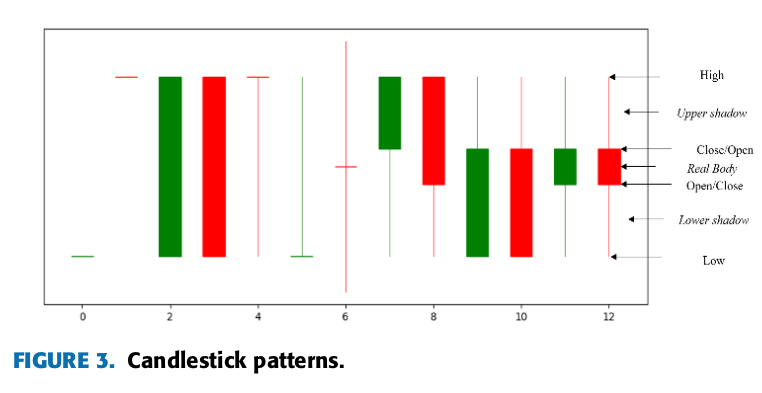
**classes:**  
0.

1.
2. CDLMARUBOZU - -100
3. CDLMARUBOZU - 100
4. CDLDOJI, 100, 收盤價 = 最高價
5. CDLDOJI, -100, 收盤價 = 最低價
6. CDLDOJI, 100, except 4 and 5
7. CDLHAMMER, -100 開盤價 = 最高價
8. CDLHAMMER, 100 收盤價 = 最高價
9. CDLINVERTEDHAMMER, -100 收盤價 = 最低價
10. CDLINVERTEDHAMMER, 100 開盤價 = 最低價
11. CDLSHORTLINE, CDLLONGLINE, -100
12. CDLSHORTLINE, CDLLONGLINE, 100


In [25]:
import talib as ta

display(ta.CDLDOJI(1.0, 1.0, 1.0, 1.0))

TypeError: Argument 'open' has incorrect type (expected numpy.ndarray, got float)

In [ ]:
from candle_patterns import cs_patterns_rest


def create_signals(data):
    """
    Creates technical trading signals based on candlestick charting patterns.

    Args:
        data (pandas.DataFrame): A dataframe of OHLCV (Open, High, Low, Close, Volume) data.

    Returns:
        pandas.DataFrame: A dataframe of OHLCV data with additional columns for each signal generated.
    """

    for signal in cs_patterns_rest:
        try:
            values = cs_patterns_rest[signal](
                data.Open, data.High, data.Low, data.Close
            )
            data[signal] = values
        except Exception as e:
            print(str(e))
    data = data.reset_index()

    return data

In [ ]:
def format_data(
    df,
    short_ind=5,
    long_ind=10,
    custom=True,
    trigrams=True,
    patterns=True,
    avg_days=5,
    additional=["O", "M", "V"],
):
    """Takes input features and creates TA indicators, the 8-trigram scheme and Target labels.

    Parameters
    ----------
    df:
        Pandas DataFrame containing Open, High, Low, Close, Volume and Date columns.
    start_time:
        Start time in datetime format when the stock is purchased
    end_time:
        End time in datetime format when the stock is sold
    custom:
        Boolean Value to specify whether to create custom signals or not
    trigrams:
        Boolean value to specify whether to calculate 8 Trigrams or not
    patterns:
        Boolean Value to specify whether to calculate typical candlestick patterns or not
    avg_days:
        Integer denoting the number of days for which rolling average has to be calculated
    additional:
        List containing values O,M,V which specify which additional stock market indicators are to be calculated

    Returns
    ----------
    Pandas DataFrame with columns -
        Updated Open, High, Low and Closing Prices, Volume, Trigrams, Target and optionally Short Line Cdl, Long Line Cdl, Spinning Top and Closing Marubozu (if custom signals are required)
    """
    import talib as tb

    # OVERLAP INDICATORS

    data = pd.DataFrame()
    data["ma"] = tb.MA(df["Close"], timeperiod=short_ind)
    data["ema"] = tb.EMA(df["Close"], timeperiod=long_ind)
    data["dema"] = tb.DEMA(df["Close"], timeperiod=short_ind)
    data["kama"] = tb.KAMA(df["Close"], timeperiod=short_ind)
    data["sma"] = tb.SMA(df["Close"], timeperiod=long_ind)
    data["sar"] = tb.SAR(df["High"], df["Low"])

    # MOMENTUM INDICATORS
    data["adx"] = tb.ADX(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
    data["cci"] = tb.CCI(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
    data["apo"] = tb.APO(df["Close"], fastperiod=long_ind, slowperiod=short_ind)
    data["bop"] = tb.BOP(df["Open"], df["High"], df["Low"], df["Close"])
    data["macd"], data["macdsignal"], data["macdhist"] = tb.MACD(
        df["Close"], fastperiod=12, slowperiod=26, signalperiod=9
    )
    data["mfi"] = tb.MFI(
        df["High"], df["Low"], df["Close"], df["Volume"], timeperiod=long_ind
    )
    data["mom"] = tb.MOM(df["Close"], timeperiod=long_ind)
    data["rsi"] = tb.RSI(df["Close"], timeperiod=long_ind)

    # VOLUME INDICATORS
    data["ad"] = tb.AD(df["High"], df["Low"], df["Close"], df["Volume"])
    data["adosc"] = tb.ADOSC(
        df["High"],
        df["Low"],
        df["Close"],
        df["Volume"],
        fastperiod=short_ind,
        slowperiod=long_ind,
    )
    data["obv"] = tb.OBV(df["Close"], df["Volume"])
    data["trange"] = tb.TRANGE(df["High"], df["Low"], df["Close"])
    data["atr"] = tb.ATR(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
    data["natr"] = tb.NATR(df["High"], df["Low"], df["Close"], timeperiod=long_ind)

    data.reset_index(drop=True, inplace=True)

    # 8 TRIGRAMS  ☰ ☱ ☲ ☳ ☴ ☵ ☶ ☷ : ⚊ ⚋

    if trigrams == True:
        trigrams = []
        for i in range(1, len(df)):
            trigram = [
                "⚊" if (df.loc[i, "High"] > df.loc[i - 1, "High"]) else "⚋",
                "⚊" if (df.loc[i, "Close"] > df.loc[i - 1, "Close"]) else "⚋",
                "⚊" if (df.loc[i, "Low"] > df.loc[i - 1, "Low"]) else "⚋",
            ]

            if trigram == ["⚋", "⚊", "⚊"]:  # "BullishHarami" ☱
                signal = 100
            elif trigram == ["⚊", "⚊", "⚋"]:  # "BullishHorn" ☴
                signal = 100
            elif trigram == ["⚊", "⚊", "⚊"]:  # "BullishHigh" ☰
                signal = 100
            elif trigram == ["⚋", "⚊", "⚋"]:  # "BullishLow" ☵
                signal = 100
            elif trigram == ["⚋", "⚋", "⚊"]:  # "BearHarami" ☳
                signal = -100
            elif trigram == ["⚊", "⚋", "⚋"]:  # "BearHorn" ☶
                signal = -100
            elif trigram == ["⚊", "⚋", "⚊"]:  # "BearHigh" ☲
                signal = -100
            elif trigram == ["⚋", "⚋", "⚋"]:  # "BearLow" ☷
                signal = -100
            else:
                signal = 0
            trigrams.append(signal)
            """ 
            if (
                (df.loc[i, "High"] > df.loc[i - 1, "High"])
                & (df.loc[i, "Low"] < df.loc[i - 1, "Low"])
                & (df.loc[i, "Close"] > df.loc[i - 1, "Close"])
            ):
                signal = 100  # "BullishHorn"
            elif (
                (df.loc[i, "High"] > df.loc[i - 1, "High"])
                & (df.loc[i, "Low"] < df.loc[i - 1, "Low"])
                & (df.loc[i, "Close"] < df.loc[i - 1, "Close"])
            ):
                signal = -100  # "BearHorn"
            elif (
                (df.loc[i, "High"] > df.loc[i - 1, "High"])
                & (df.loc[i, "Low"] > df.loc[i - 1, "Low"])
                & (df.loc[i, "Close"] > df.loc[i - 1, "Close"])
            ):
                signal = 100  # "BullishHigh"
            elif (
                (df.loc[i, "High"] > df.loc[i - 1, "High"])
                & (df.loc[i, "Low"] > df.loc[i - 1, "Low"])
                & (df.loc[i, "Close"] < df.loc[i - 1, "Close"])
            ):
                signal = -100  # "BearHigh"
            elif (
                (df.loc[i, "High"] < df.loc[i - 1, "High"])
                & (df.loc[i, "Low"] < df.loc[i - 1, "Low"])
                & (df.loc[i, "Close"] > df.loc[i - 1, "Close"])
            ):
                signal = 100  # "BullishLow"
            elif (
                (df.loc[i, "High"] < df.loc[i - 1, "High"])
                & (df.loc[i, "Low"] < df.loc[i - 1, "Low"])
                & (df.loc[i, "Close"] < df.loc[i - 1, "Close"])
            ):
                signal = -100  # "BearLow"
            elif (
                (df.loc[i, "High"] < df.loc[i - 1, "High"])
                & (df.loc[i, "Low"] > df.loc[i - 1, "Low"])
                & (df.loc[i, "Close"] > df.loc[i - 1, "Close"])
            ):
                signal = 100  # "BullishHarami"
            elif (
                (df.loc[i, "High"] < df.loc[i - 1, "High"])
                & (df.loc[i, "Low"] > df.loc[i - 1, "Low"])
                & (df.loc[i, "Close"] < df.loc[i - 1, "Close"])
            ):
                signal = -100  # "BearHarami"
            else:
                signal = 0
            trigrams.append(signal)
            """
    else:
        trigrams = [0] * (len(df.index) - 1)

    data.drop(df.index[0], inplace=True)
    data["trigrams"] = trigrams

    # TARGET
    data["target"] = df["Close"].pct_change().rolling(avg_days).mean().shift(avg_days)

    data.dropna(inplace=True)

    columns = ["Open", "High", "Volume", "Low", "trigrams", "target"]

    if custom == True:
        df = create_signals(data=df)
        columns = columns + [
            "shortLineCdl",
            "longLineCdl",
            "spinningTop",
            "closingMarubozu",
        ]

    if "O" in additional:
        columns = columns + ["ma", "ema", "dema", "kama", "sma", "sar"]
    if "M" in additional:
        columns = columns + ["adx", "cci", "apo", "bop", "macd", "mfi", "mom", "rsi"]
    if "V" in additional:
        columns = columns + ["ad", "adosc", "obv", "trange", "atr", "natr"]

    df = df[columns]

    return df

In [ ]:
a = ["⚊", "⚋", "⚊"]
b = ["⚊", "⚋", "⚊"]
c = ["⚊", "⚋", "⚋"]
d = ["⚊", "⚋", "⚋"]
display(a == b)
display(a == c)
display(b == c)
display(d == c)

True

False

False

True

In [96]:
candle_rankings = {
    "CDL3LINESTRIKE_Bull": 1,
    "CDL3LINESTRIKE_Bear": 2,
    "CDL3BLACKCROWS_Bull": 3,
    "CDL3BLACKCROWS_Bear": 3,
    "CDLEVENINGSTAR_Bull": 4,
    "CDLEVENINGSTAR_Bear": 4,
    "CDLTASUKIGAP_Bull": 5,
    "CDLTASUKIGAP_Bear": 5,
    "CDLINVERTEDHAMMER_Bull": 6,
    "CDLINVERTEDHAMMER_Bear": 6,
    "CDLMATCHINGLOW_Bull": 7,
    "CDLMATCHINGLOW_Bear": 7,
    "CDLABANDONEDBABY_Bull": 8,
    "CDLABANDONEDBABY_Bear": 8,
    "CDLBREAKAWAY_Bull": 10,
    "CDLBREAKAWAY_Bear": 10,
    "CDLMORNINGSTAR_Bull": 12,
    "CDLMORNINGSTAR_Bear": 12,
    "CDLPIERCING_Bull": 13,
    "CDLPIERCING_Bear": 13,
    "CDLSTICKSANDWICH_Bull": 14,
    "CDLSTICKSANDWICH_Bear": 14,
    "CDLTHRUSTING_Bull": 15,
    "CDLTHRUSTING_Bear": 15,
    "CDLCOUNTERATTACK_Bear": 16,
    "CDLCOUNTERATTACK_Bull": 18,
    "CDLINNECK_Bull": 17,
    "CDLINNECK_Bear": 17,
    "CDL3INSIDE_Bull": 20,
    "CDL3INSIDE_Bear": 56,
    "CDLHOMINGPIGEON_Bull": 21,
    "CDLHOMINGPIGEON_Bear": 21,
    "CDLDARKCLOUDCOVER_Bull": 22,
    "CDLDARKCLOUDCOVER_Bear": 22,
    "CDLIDENTICAL3CROWS_Bull": 24,
    "CDLIDENTICAL3CROWS_Bear": 24,
    "CDLMORNINGDOJISTAR_Bull": 25,
    "CDLMORNINGDOJISTAR_Bear": 25,
    "CDLXSIDEGAP3METHODS_Bull": 27,
    "CDLXSIDEGAP3METHODS_Bear": 26,
    "CDLTRISTAR_Bull": 28,
    "CDLTRISTAR_Bear": 76,
    "CDLGAPSIDESIDEWHITE_Bull": 46,
    "CDLGAPSIDESIDEWHITE_Bear": 29,
    "CDLEVENINGDOJISTAR_Bull": 30,
    "CDLEVENINGDOJISTAR_Bear": 30,
    "CDL3WHITESOLDIERS_Bull": 32,
    "CDL3WHITESOLDIERS_Bear": 32,
    "CDLONNECK_Bull": 33,
    "CDLONNECK_Bear": 33,
    "CDL3OUTSIDE_Bull": 34,
    "CDL3OUTSIDE_Bear": 39,
    "CDLRICKSHAWMAN_Bull": 35,
    "CDLRICKSHAWMAN_Bear": 35,
    "CDLSEPARATINGLINES_Bull": 36,
    "CDLSEPARATINGLINES_Bear": 40,
    "CDLLONGLEGGEDDOJI_Bull": 37,
    "CDLLONGLEGGEDDOJI_Bear": 37,
    "CDLHARAMI_Bull": 38,
    "CDLHARAMI_Bear": 72,
    "CDLLADDERBOTTOM_Bull": 41,
    "CDLLADDERBOTTOM_Bear": 41,
    "CDLCLOSINGMARUBOZU_Bull": 70,
    "CDLCLOSINGMARUBOZU_Bear": 43,
    "CDLTAKURI_Bull": 47,
    "CDLTAKURI_Bear": 47,
    "CDLDOJISTAR_Bull": 49,
    "CDLDOJISTAR_Bear": 51,
    "CDLHARAMICROSS_Bull": 50,
    "CDLHARAMICROSS_Bear": 80,
    "CDLADVANCEBLOCK_Bull": 54,
    "CDLADVANCEBLOCK_Bear": 54,
    "CDLSHOOTINGSTAR_Bull": 55,
    "CDLSHOOTINGSTAR_Bear": 55,
    "CDLMARUBOZU_Bull": 71,
    "CDLMARUBOZU_Bear": 57,
    "CDLUNIQUE3RIVER_Bull": 60,
    "CDLUNIQUE3RIVER_Bear": 60,
    "CDL2CROWS_Bull": 61,
    "CDL2CROWS_Bear": 61,
    "CDLBELTHOLD_Bull": 62,
    "CDLBELTHOLD_Bear": 63,
    "CDLHAMMER_Bull": 65,
    "CDLHAMMER_Bear": 65,
    "CDLSHORTLINE_Bull": 85,
    "CDLSHORTLINE_Bear": 66,
    "CDLHIGHWAVE_Bull": 67,
    "CDLHIGHWAVE_Bear": 67,
    "CDLLONGLINE_Bull": 68,
    "CDLLONGLINE_Bear": 82,
    "CDLSPINNINGTOP_Bull": 69,
    "CDLSPINNINGTOP_Bear": 73,
    "CDLUPSIDEGAP2CROWS_Bull": 74,
    "CDLUPSIDEGAP2CROWS_Bear": 74,
    "CDLGRAVESTONEDOJI_Bull": 77,
    "CDLGRAVESTONEDOJI_Bear": 77,
    "CDLHIKKAKEMOD_Bull": 82,
    "CDLHIKKAKEMOD_Bear": 81,
    "CDLHIKKAKE_Bull": 85,
    "CDLHIKKAKE_Bear": 83,
    "CDLENGULFING_Bull": 84,
    "CDLENGULFING_Bear": 91,
    "CDLMATHOLD_Bull": 86,
    "CDLMATHOLD_Bear": 86,
    "CDLHANGINGMAN_Bull": 87,
    "CDLHANGINGMAN_Bear": 87,
    "CDLSTALLEDPATTERN_Bull": 93,
    "CDLSTALLEDPATTERN_Bear": 93,
    "CDLRISEFALL3METHODS_Bull": 94,
    "CDLRISEFALL3METHODS_Bear": 89,
    "CDLKICKING_Bull": 96,
    "CDLKICKING_Bear": 102,
    "CDLDRAGONFLYDOJI_Bull": 98,
    "CDLDRAGONFLYDOJI_Bear": 98,
    "CDLCONCEALBABYSWALL_Bull": 101,
    "CDLCONCEALBABYSWALL_Bear": 101,
    "CDLKICKINGBYLENGTH_Bear": 102,
    "CDLKICKINGBYLENGTH_Bull": 102,
    "CDL3STARSINSOUTH_Bull": 103,
    "CDL3STARSINSOUTH_Bear": 103,
    "CDLDOJI_Bull": 104,
    "CDLDOJI_Bear": 104,
}

In [97]:
from itertools import compress

# from .candle_rankings import candle_rankings

candle_names = ta.get_function_groups()["Pattern Recognition"]

# # patterns not found in the patternsite.com
# exclude_items = (
#     "CDLCOUNTERATTACK",
#     'CDLLONGLINE',
#     'CDLSHORTLINE',
#     "CDLSTALLEDPATTERN",
#     "CDLKICKINGBYLENGTH",
# )
# candle_names = [candle for candle in candle_names if candle not in exclude_items]


df = stks_data[4].tick_data.copy()
display(df)

op = df["Open"]
hi = df["High"]
lo = df["Low"]
cl = df["Close"]
candle_values = pd.DataFrame(index=df.index)
for candle in candle_names:
    candle_values[candle] = getattr(ta, candle)(op, hi, lo, cl)


candle_values["candlestick_pattern"] = np.nan
candle_values["candlestick_match_count"] = np.nan
for index, row in candle_values.iterrows():

    # no pattern found
    if len(row[candle_names]) - sum(row[candle_names] == 0) == 0:
        candle_values.loc[index, "candlestick_pattern"] = "NO_PATTERN"
        candle_values.loc[index, "candlestick_match_count"] = 0
    # single pattern found
    elif len(row[candle_names]) - sum(row[candle_names] == 0) == 1:
        # bull pattern 100 or 200
        if any(row[candle_names].values > 0):
            pattern = (
                list(compress(row[candle_names].keys(), row[candle_names].values != 0))[
                    0
                ]
                + "_Bull"
            )
            candle_values.loc[index, "candlestick_pattern"] = pattern
            candle_values.loc[index, "candlestick_match_count"] = 1
        # bear pattern -100 or -200
        else:
            pattern = (
                list(compress(row[candle_names].keys(), row[candle_names].values != 0))[
                    0
                ]
                + "_Bear"
            )
            candle_values.loc[index, "candlestick_pattern"] = pattern
            candle_values.loc[index, "candlestick_match_count"] = 1
    # multiple patterns matched -- select best performance
    else:
        # filter out pattern names from bool list of values
        patterns = list(
            compress(row[candle_names].keys(), row[candle_names].values != 0)
        )
        container = []
        for pattern in patterns:
            if row[pattern] > 0:
                container.append(pattern + "_Bull")
            else:
                container.append(pattern + "_Bear")
        rank_list = [candle_rankings[p] for p in container]
        if len(rank_list) == len(container):
            rank_index_best = rank_list.index(min(rank_list))
            candle_values.loc[index, "candlestick_pattern"] = container[rank_index_best]
            candle_values.loc[index, "candlestick_match_count"] = len(container)

# clean up candle columns
# cols_to_drop = candle_names + list(exclude_items)
# candle_values.drop(cols_to_drop, axis=1, inplace=True)
df1 = df.loc[candle_values[(candle_values["candlestick_match_count"] == 0)].index]
df1

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.846,19.894,19.715,19.755,17.297,234684800
2014-01-03,19.745,19.775,19.301,19.321,16.917,392467600
2014-01-06,19.195,19.529,19.057,19.426,17.009,412610800
2014-01-07,19.440,19.499,19.211,19.287,16.887,317209200
2014-01-08,19.243,19.484,19.239,19.409,16.994,258529600
...,...,...,...,...,...,...
2023-12-22,195.180,195.410,192.970,193.600,193.353,37122800
2023-12-26,193.610,193.890,192.830,193.050,192.804,28919300
2023-12-27,192.490,193.500,191.090,193.150,192.904,48087700


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.846,19.894,19.715,19.755,17.297,234684800
2014-01-03,19.745,19.775,19.301,19.321,16.917,392467600
2014-01-06,19.195,19.529,19.057,19.426,17.009,412610800
2014-01-07,19.440,19.499,19.211,19.287,16.887,317209200
2014-01-08,19.243,19.484,19.239,19.409,16.994,258529600
...,...,...,...,...,...,...
2023-10-26,170.370,171.380,165.670,166.890,166.458,70625300
2023-11-17,190.250,190.380,188.570,189.690,189.448,50922700
2023-12-21,196.100,197.080,193.500,194.680,194.432,46482500


In [101]:
len(candle_values.candlestick_pattern.unique())

57

In [82]:
all_candle_names = ta.get_function_groups()["Pattern Recognition"]
op1 = df1["Open"]
hi1 = df1["High"]
lo1 = df1["Low"]
cl1 = df1["Close"]
for candle in all_candle_names:
    df1[candle] = getattr(ta, candle)(op1, hi1, lo1, cl1)

df1
# clean up candle columns
# cols_to_drop = candle_names + list(exclude_items)
# df.derop(cols_to_drop, axis = 1, inplace = True)
# candle_values
# buy_cnt = (df == 100).sum().sum()
# sell_cnt = (df == -100).sum().sum()
# display(f"buy_cnt:{buy_cnt}, sell_cnt:{sell_cnt}")

# display((df.iloc[:, 6:] != 100.0) & (df.iloc[:, 6:] != -100.0))
# display(df.iloc[:, 6:][(df.iloc[:, 6:] != 100.0) & (df.iloc[:, 6:] != -100.0)])

# with show_more_rows():
#     display((df == 100).sum())

,Open,High,Low,Close,Adj Close,Volume,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-02,19.846,19.894,19.715,19.755,17.297,234684800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-03,19.745,19.775,19.301,19.321,16.917,392467600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-06,19.195,19.529,19.057,19.426,17.009,412610800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-07,19.440,19.499,19.211,19.287,16.887,317209200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-08,19.243,19.484,19.239,19.409,16.994,258529600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,196.100,197.080,193.500,194.680,194.432,46482500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2023-12-26,193.610,193.890,192.830,193.050,192.804,28919300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-100,0,0,0,0,0,0,0,0,0,0
2023-12-27,192.490,193.500,191.090,193.150,192.904,48087700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [93]:
df2 = df1.iloc[:, 6:]
with show_more_rows():
    display((df2 != 0).any())

CDL2CROWS              False
CDL3BLACKCROWS         False
CDL3INSIDE              True
CDL3LINESTRIKE         False
CDL3OUTSIDE             True
CDL3STARSINSOUTH       False
CDL3WHITESOLDIERS      False
CDLABANDONEDBABY       False
CDLADVANCEBLOCK        False
CDLBELTHOLD             True
CDLBREAKAWAY           False
CDLCLOSINGMARUBOZU      True
CDLCONCEALBABYSWALL    False
CDLCOUNTERATTACK        True
CDLDARKCLOUDCOVER       True
CDLDOJI                 True
CDLDOJISTAR            False
CDLDRAGONFLYDOJI        True
CDLENGULFING            True
CDLEVENINGDOJISTAR     False
CDLEVENINGSTAR          True
CDLGAPSIDESIDEWHITE     True
CDLGRAVESTONEDOJI       True
CDLHAMMER               True
CDLHANGINGMAN           True
CDLHARAMI               True
CDLHARAMICROSS          True
CDLHIGHWAVE            False
CDLHIKKAKE              True
CDLHIKKAKEMOD           True
CDLHOMINGPIGEON         True
CDLIDENTICAL3CROWS     False
CDLINNECK              False
CDLINVERTEDHAMMER       True
CDLKICKING    

In [ ]:
00
        else:
            pattern = list(compress(row[candle_names].keys(), row[candle_names].values != 0))[0] + '_Bear'
            candle_values.loc[index, "candlestick_pattern"] = pattern
            candle_values.loc[index, "candlestick_match_count"] = 1
    # multiple patterns matched -- select best performance
    else:
        # filter out pattern names from bool list of values
        patterns = list(compress(row[candle_names].keys(), row[candle_names].values != 0))
        container = []
        for pattern in patterns:
            if row[pattern] > 0:
                container.append(pattern + '_Bull')
            else:
                container.append(pattern + '_Bear')
        rank_list = [candle_rankings[p] for p in container]
        if len(rank_list) == len(container):
            rank_index_best = rank_list.index(min(rank_list))
            candle_values.loc[index, "candlestick_pattern"] = container[rank_index_best]
            candle_values.loc[index, "candlestick_match_count"] = len(container)

# clean up candle columns
# cols_to_drop = candle_names + list(exclude_items)
# candle_values.drop(cols_to_drop, axis=1, inplace=True)
df1 = df.loc[candle_values[(candle_values["candlestick_match_count"] == 0)].index]
df1


In [ ]:
# clean up candle columns
# cols_to_drop = candle_names + list(exclude_items)
# df.derop(cols_to_drop, axis = 1, inplace = True)
# candle_values
# buy_cnt = (df == 100).sum().sum()
# sell_cnt = (df == -100).sum().sum()
# display(f"buy_cnt:{buy_cnt}, sell_cnt:{sell_cnt}")

# display((df.iloc[:, 6:] != 100.0) & (df.iloc[:, 6:] != -100.0))
# display(df.iloc[:, 6:][(df.iloc[:, 6:] != 100.0) & (df.iloc[:, 6:] != -100.0)])

# with show_more_rows():
#     display((df == 100).sum())

In [ ]:
def gen_buy_sell_signal(stk_data):
    import pandas_ta as ta

    sma = pd.concat(
        [
            stk_data.ta.sma(close="Adj Close", length=10),
            stk_data.ta.sma(close="Adj Close", length=60),
        ],
        axis=1,
    ).dropna()
    buy_signal = sma["SMA_10"] > sma["SMA_60"]

    buy_sell_signal = stk_data[[]].copy()
    buy_sell_signal["Signal"] = (buy_signal).astype("int")

    return buy_sell_signal


expected_features_size = 14  # 17


def gen_analysis_data(stk_data, _return_period):
    import pandas_ta as ta

    try:
        adjusted_OHLV = to_adjusted(stk_data)
        data = pd.concat(
            [
                # OVERLAP INDICATORS
                stk_data.ta.adjusted_OHLV.ta.adosc(
                    high="Adj High",
                    low="Adj Low",
                    close="Adj Close",
                    volume="Adj Volume",
                    prefix="B2",
                ),
                adjusted_OHLV.ta.kvo(
                    high="Adj High",
                    low="Adj Low",
                    close="Adj Close",
                    volume="Adj Volume",
                    prefix="B2",
                ),
                stk_data.ta.rsi(close="Adj Close", length=7, prefix="B3"),
                stk_data.ta.rsi(close="Adj Close", length=14, prefix="B3"),
                # stk_data.ta.rsi(close="Adj Close", length=200, prefix="B3"),
                stk_data.ta.stoch(k=10, prefix="B3"),
                stk_data.ta.stoch(k=30, prefix="B3"),
                # stk_data.ta.stoch(k=200, prefix="B3"),
                stk_data.ta.cci(7, prefix="B3"),
                stk_data.ta.cci(14, prefix="B3"),
                adjusted_OHLV.loc[
                    :,
                    [
                        "B4_Adj Open pct",
                        "B4_Adj High pct",
                        "B4_Adj Low pct",
                        "B4_Adj Volume pct",
                    ],
                ],
                gen_buy_sell_signal(stk_data),
            ],
            axis=1,
        )

        data = pd.concat(
            [data.astype("float32"), gen_pct_label(stk_data, _return_period)],
            axis=1,
        ).dropna()
    except:
        data = None
    return data

In [ ]:
import pandas as pd
import talib as ta
import numpy as np


def initialize(ctx):
    candle = ta.CDLXSIDEGAP3METHODS
    ctx.logger.debug("initialize() called")
    ctx.configure(
        channels={
            "jp.stock": {
                "symbols": [
                    "jp.stock.2914",
                    "jp.stock.3382",
                    "jp.stock.4063",
                    "jp.stock.4452",
                    "jp.stock.4502",
                    "jp.stock.4503",
                    "jp.stock.6098",
                    "jp.stock.6501",
                    "jp.stock.6752",
                    "jp.stock.6758",
                    "jp.stock.6861",
                    "jp.stock.6954",
                    "jp.stock.6981",
                    "jp.stock.7203",
                    "jp.stock.7267",
                    "jp.stock.7751",
                    "jp.stock.7974",
                    "jp.stock.8031",
                    "jp.stock.8316",
                    "jp.stock.8411",
                    "jp.stock.8766",
                    "jp.stock.8802",
                    "jp.stock.9020",
                    "jp.stock.9022",
                    "jp.stock.9432",
                    "jp.stock.9433",
                    "jp.stock.9437",
                    "jp.stock.9984",
                ],
                "columns": [
                    "open_price_adj",  # 始値(株式分割調整後)
                    "high_price_adj",  # 高値(株式分割調整後)
                    "low_price_adj",  # 安値(株式分割調整後)
                    "close_price_adj",  # 終値(株式分割調整後)
                ],
            }
        }
    )

    def _my_signal(data):
        op = data["open_price_adj"].fillna(method="ffill")
        cp = data["close_price_adj"].fillna(method="ffill")
        hp = data["high_price_adj"].fillna(method="ffill")
        lp = data["low_price_adj"].fillna(method="ffill")
        sig = pd.DataFrame(data=0, columns=[], index=cp.index)

        for sym, val in cp.items():
            sig[sym] = candle(op[sym], hp[sym], lp[sym], cp[sym])

        def prints(*args):
            ctx.logger.debug(" ".join(map(str, args)))

        # prints(sig)

        buy_sig_count = 0
        sell_sig_count = 0
        for i in sig:
            buy_sig_count += (sig[i] == 100).sum()
            sell_sig_count += (sig[i] == -100).sum()

        prints("buy_sig_count", buy_sig_count)
        prints("sell_sig_count", sell_sig_count)

        return {
            "count": sig,
        }

    # シグナル登録
    ctx.regist_signal("my_signal", _my_signal)


def handle_signals(ctx, date, current):
    """
    current: pd.DataFrame
    """

    done_syms = set([])
    count = current["count"].dropna()

    buy_sig = count[(count == 100)]
    sell_sig = count[(count == -100)]

    for sym, val in buy_sig.items():
        sec = ctx.getSecurity(sym)
        sec.order_target_percent(0.8, comment="SAMPLE BUY")

    for sym, val in sell_sig.items():
        sec = ctx.getSecurity(sym)
        sec.order_target_percent(0, comment="SAMPLE SELL")